<a href="https://colab.research.google.com/github/mtsilimos/ETH/blob/main/CV_TRANSFORMERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!pip install transformers -q

[]

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete66OCWL/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete66OCWL/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
import tensorflow as tf
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [4]:
auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

In [5]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


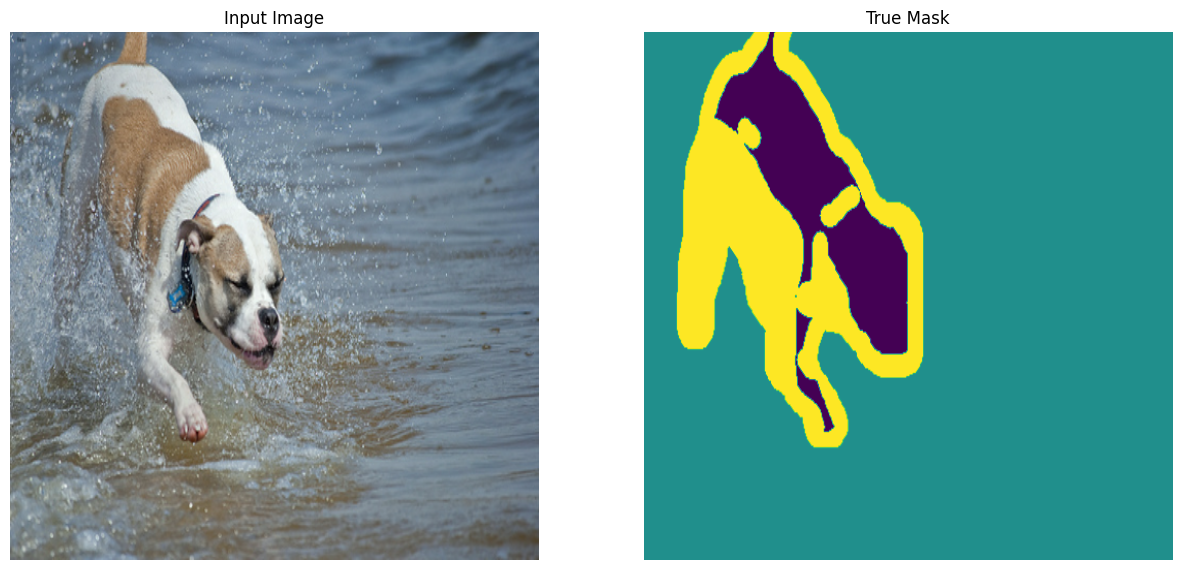

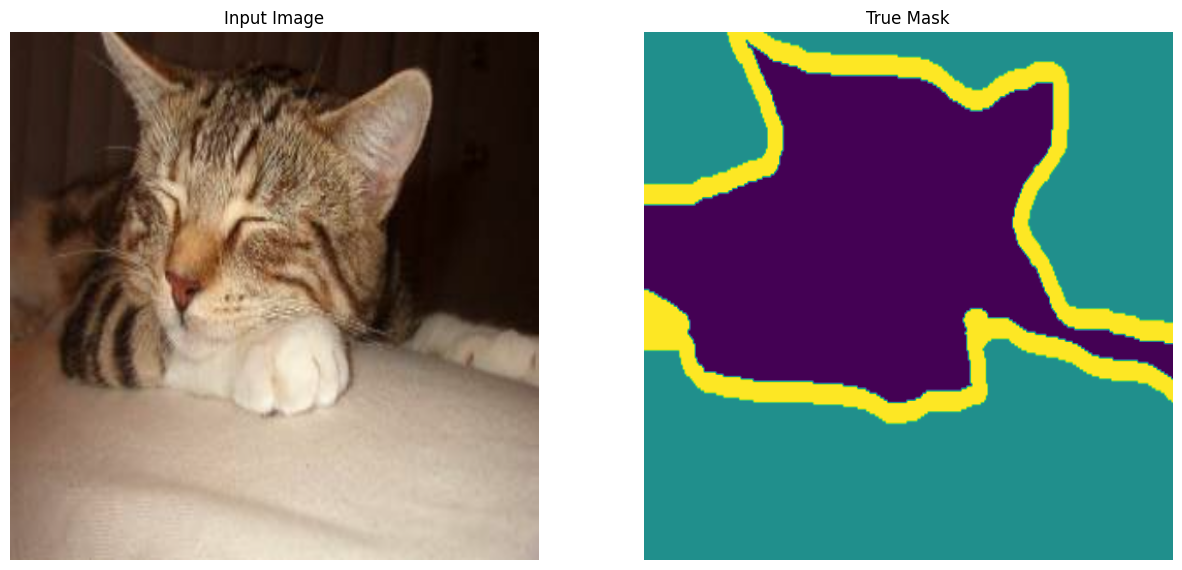

In [6]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [7]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [9]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [ ]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 3

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=epochs,
)